In [2]:
# -*- coding: utf-8 -*-

In [2]:
tutorial='https://notebook.community/jmschrei/pomegranate/tutorials/B_Model_Tutorial_4_Bayesian_Networks'
pip install pomegranate

distutils: /home/consulting/anaconda2/envs/py35/include/python3.8/UNKNOWN
sysconfig: /home/consulting/anaconda2/envs/py35/include/python3.8
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 20.9 MB 14.5 MB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 39.6 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
distutils: /home/consulting/anaconda2/envs/py35/include/python3.8/UNKNOWN
sysconfig: /home/consulting/anaconda2/envs/py35/include/python3.8
user = False
home = None
root = None
prefix = None
You should consider upgrading via the '/home/consulting/anaconda2/envs/py35/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### 확률 계산

#### 조건부확률

In [1]:
def get_conditional_prob(df, child, parent1=None, parent2=None):
    p_list=[]
    if parent1==None:
        #print('no parent')
        
        child_values = df[child].unique()

        idx = df[child].value_counts(normalize=True).index
        p = df[child].value_counts(normalize=True).values
        p_list += [[i,j] for i,j in zip(idx,p)]
        for childv in child_values:
            if childv not in idx:
                p_list += [childv,0]


    elif (parent1!=None) and (parent2==None):
        #print('parent1')
        
        child_values = df[child].unique()
        parent1_values = df[parent1].unique()

        for par1 in parent1_values:
            idx = df[df[parent1]==par1][child].value_counts(normalize=True).index
            p = df[df[parent1]==par1][child].value_counts(normalize=True).values
            p_list += [[par1,childv,p] for childv,p in zip(idx,p)]
            #0일 땐 value_counts에 포함이 안되어서 따로 넣어줌
            for childv in child_values:
                if childv not in idx:
                    p_list += [[par1, childv, 0]]

            #parent_value별 조건부확률 누적 값은 1이 되어야 함
            #print(sum(p))

    elif (parent1!=None) and (parent2!=None):  
        #print('parent2')
        
        child_values = df[child].unique()
        parent1_values = df[parent1].unique()
        parent2_values = df[parent2].unique()

        for par1 in parent1_values:
            for par2 in parent2_values:
                
                idx = df[(df[parent1]==par1) & (df[parent2]==par2)][child].value_counts(normalize=True).index
                p = df[(df[parent1]==par1) & (df[parent2]==par2)][child].value_counts(normalize=True).values
                p_list += [[par1,par2,childv,p] for childv,p in zip(idx,p)]

                #0일 땐 value_counts에 포함이 안되어서 따로 넣어줌
                for childv in child_values:
                    if childv not in idx:
                        p_list += [[par1, par2, childv,0]]
                #parent_value별 조건부확률 누적 값은 1이 되어야 함
                #print(sum(p))
    
    return p_list

    
    

#### 결합확률

In [99]:
var1 = '기상상태'
var2 = '발생해역'
var3 = '관할해경서'

def get_joint_prob(df, var1, var2=None, var3=None):

    if var2 == None:
        probability = {}

        p = df[child].value_counts(normalize=True)
        for i in p.keys():
            probability[i] = p[i]

    elif (var2 != None) & (var3 == None):
        total = len(df)
        probability = []

        for i in df[var1].unique():
            for j in df[var2].unique():

                cnt = len(df[(df[var1]==i) & (df[var2]==j)])
                joint_p = cnt/total

                ll = []
                ll.append(i)
                ll.append(j)
                ll.append(joint_p)
                probability.append(ll)

    elif var3 != None:
        total = len(df)
        probability = []

        for i in df[var1].unique():
            for j in df[var2].unique():
                for k in df[var3].unique():
                    cnt = len(df[(df[var1]==i) & (df[var2]==j) & (df[var3]==k)])
                    joint_p = cnt/total

                    ll = []
                    ll.append(i)
                    ll.append(j)
                    ll.append(k)
                    ll.append(joint_p)
                    probability.append(ll)


    c=0    
    for i in probability:
        c+=i[-1]
    #print(c)
    
    return probability

#함수호출 예시
#get_joint_prob(df, var1 = '기상상태', var2 = '발생해역', var3 = '관할해경서')

### 베이지안네트워크 구축

In [2]:
import pandas as pd
from pomegranate import * 
from sklearn.model_selection import train_test_split

#### 데이터 불러오기

In [3]:
df=pd.read_csv('./Data/해양경찰청_해상조난사고_상세데이터_현황_20191231.csv', encoding='euckr')
df.rename(columns={'선 종':'선종'},inplace=True)
df = df[['발생일시','관할해경서','발생해역','기상상태','발생원인','발생유형','선종']]
df = df.drop_duplicates()
df['사고월']=df['발생일시'].apply(lambda x: 'January' if x.split('-')[1]=='01' \
                                    else 'February' if x.split('-')[1]=='02'\
                                    else 'March' if x.split('-')[1]=='03'\
                                    else 'April' if x.split('-')[1]=='04'\
                                    else 'May' if x.split('-')[1]=='05'\
                                    else 'June' if x.split('-')[1]=='06'\
                                    else 'July' if x.split('-')[1]=='07'\
                                    else 'August' if x.split('-')[1]=='08'\
                                    else 'September' if x.split('-')[1]=='09'\
                                    else 'October' if x.split('-')[1]=='10'\
                                    else 'November' if x.split('-')[1]=='11'\
                                    else 'December' if x.split('-')[1]=='12'\
                                    else 'etc'
                           )



# train set, test set split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
df

,발생일시,관할해경서,발생해역,기상상태,발생원인,발생유형,선종,사고월
0,2019-12-31 22:04,포항,영해,양호,관리소홀,기타,모터보트,December
1,2019-12-31 15:13,포항,영해,양호,운항부주의,충돌,어선,December
2,2019-12-31 15:13,포항,영해,양호,운항부주의,충돌,화물선,December
3,2019-12-31 9:33,통영,협수로,양호,운항부주의,부유물감김,어선,December
4,2019-12-31 8:38,군산,항계 내,양호,관리소홀,침수,어선,December
...,...,...,...,...,...,...,...,...
3815,2019-01-01 14:08,인천,영해,양호,운항부주의,부유물감김,모터보트,January
3816,2019-01-01 9:14,인천,협수로,양호,운항부주의,침수,어선,January
3817,2019-01-01 7:59,완도,항계 내,양호,운항부주의,좌초/좌주,모터보트,January
3818,2019-01-01 3:31,태안,영해,양호,운항부주의,침몰,기타,January


#### 확률계산

In [5]:
#train set 데이터로 확률 및 조건부확률 계산

weather_p = get_conditional_prob(train_set,'기상상태')
weather_p_dic = {}
for i in weather_p:
    weather_p_dic[i[0]]=i[-1]

month_p = get_conditional_prob(train_set,'사고월', parent1='기상상태')
ocean_p = get_conditional_prob(train_set,'발생해역', parent1='기상상태')
jurisdiction_p = get_conditional_prob(train_set,'관할해경서', parent1='발생해역')
vessel_type_p = get_conditional_prob(train_set,'선종', parent1='발생해역')
cause_p = get_conditional_prob(train_set,'발생원인', parent1='발생해역')
accident_type_p = get_conditional_prob(train_set,'발생유형', parent1='발생원인')


In [6]:
weather_p

[['양호', 0.8964211975223675],
 ['저시정', 0.02752924982794219],
 ['풍랑주의보', 0.02339986235375086],
 ['태풍경보', 0.015829318651066758],
 ['황천5급', 0.015485203028217482],
 ['황천6급', 0.011011699931176875],
 ['황천4급', 0.0055058499655884375],
 ['풍랑경보', 0.0027529249827942187],
 ['태풍주의보', 0.0020646937370956643]]

In [7]:
print(sum([i[1] for i in weather_p]))

0.9999999999999999


In [62]:
month_p

[['양호', 'August', 0.11170825335892515],
 ['양호', 'September', 0.10748560460652591],
 ['양호', 'October', 0.10556621880998081],
 ['양호', 'July', 0.09443378119001919],
 ['양호', 'June', 0.08944337811900192],
 ['양호', 'May', 0.08790786948176584],
 ['양호', 'November', 0.0817658349328215],
 ['양호', 'April', 0.07562380038387716],
 ['양호', 'January', 0.06948176583493282],
 ['양호', 'March', 0.06833013435700576],
 ['양호', 'December', 0.06410748560460652],
 ['양호', 'February', 0.044145873320537425],
 ['저시정', 'July', 0.3625],
 ['저시정', 'March', 0.1375],
 ['저시정', 'August', 0.1125],
 ['저시정', 'April', 0.0875],
 ['저시정', 'June', 0.075],
 ['저시정', 'October', 0.0625],
 ['저시정', 'September', 0.05],
 ['저시정', 'May', 0.05],
 ['저시정', 'January', 0.0375],
 ['저시정', 'February', 0.0125],
 ['저시정', 'November', 0.0125],
 ['저시정', 'December', 0],
 ['황천6급', 'October', 0.25],
 ['황천6급', 'February', 0.15625],
 ['황천6급', 'May', 0.125],
 ['황천6급', 'December', 0.09375],
 ['황천6급', 'March', 0.09375],
 ['황천6급', 'November', 0.09375],
 ['황천6급', 'J

In [8]:
print(sum([i[2] for i in month_p if i[0]=='양호']))
print(sum([i[2] for i in month_p if i[0]=='저시정']))

1.0
1.0


#### 노드, 엣지 생성

In [17]:
# 모델링에 기반하여 모델 생성

# 노드 정의
weather = Node(
    DiscreteDistribution(weather_p_dic),
    name='weather'
              )

month = Node(
    ConditionalProbabilityTable(
        month_p, 
        [weather.distribution]
    )
    , name='month'
)

ocean = Node(
    ConditionalProbabilityTable(
        ocean_p, 
        [weather.distribution]
    )
    , name='ocean'
)

jurisdiction = Node(
    ConditionalProbabilityTable(
        jurisdiction_p,
        [ocean.distribution]
    )
    , name='jurisdiction'
)

vessel_type = Node(
    ConditionalProbabilityTable(
        vessel_type_p,
        [ocean.distribution]
    )
    , name='vessel_type'
)

cause = Node(
    ConditionalProbabilityTable(
        cause_p,
        [ocean.distribution]
    )
    , name='cause'
)

accident_type = Node(
    ConditionalProbabilityTable(
        accident_type_p,
        [cause.distribution]
    )
    , name='accident_type'
)


## 모델 생성
model = BayesianNetwork()
# 노드 추가 (한 개씩 추가해도 결과 같음)
model.add_states(weather, month, ocean, jurisdiction, cause, vessel_type, accident_type)

# 엣지 추가 (parent, child)
model.add_edge(weather, month)
model.add_edge(weather, ocean)
model.add_edge(ocean, jurisdiction)
model.add_edge(ocean, vessel_type)
model.add_edge(ocean, cause)
model.add_edge(cause, accident_type)



# Finalize the topology of the model.
# Assign a numerical index to every state and create the underlying arrays corresponding to the states and edges between the states. 
#This method must be called before any of the probability-calculating methods. This includes converting conditional probability tables into joint probability tables 
#and creating a list of both marginal and table nodes.
model.bake()






In [32]:
model

{
    "class" : "BayesianNetwork",
    "name" : "2488929973584",
    "structure" : [
        [],
        [
            0
        ]
    ],
    "states" : [
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "dtype" : "str",
                "name" : "DiscreteDistribution",
                "parameters" : [
                    {
                        "\uc591\ud638" : 0.8964211975223675,
                        "\uc800\uc2dc\uc815" : 0.02752924982794219,
                        "\ud48d\ub791\uc8fc\uc758\ubcf4" : 0.02339986235375086,
                        "\ud0dc\ud48d\uacbd\ubcf4" : 0.015829318651066758,
                        "\ud669\ucc9c5\uae09" : 0.015485203028217482,
                        "\ud669\ucc9c6\uae09" : 0.011011699931176875,
                        "\ud669\ucc9c4\uae09" : 0.0055058499655884375,
                        "\ud48d\ub791\uacbd\ubcf4" : 0.0027529249827942187,
                       

#### 추론

Probability

예시

In [47]:
cause_list = df.발생원인.unique().tolist()
cause_dic = {}
for i in cause_list:
    probability = model.probability([['양호', 'December', '영해', '여수', i, '어선', '기관손상']])
    cause_dic[i]=probability

cause_dic = sorted(cause_dic.items(), key=lambda x:x[1], reverse=True)    
cause_dic   

[('정비불량', 0.0001918155530334854),
 ('운항부주의', 8.088376712418298e-06),
 ('관리소홀', 1.934244268188903e-06),
 ('연료고갈', 2.6954493195451265e-07),
 ('화기취급부주의', 9.795492514637682e-08),
 ('안전부주의', 0.0),
 ('기타 ', 0.0),
 ('기상악화', 0.0),
 ('기상악화(인명은 기타)', 0.0),
 ('적재불량', 0.0),
 ('재질불량', 0.0)]

학습

In [48]:
# 확률 계산

cause_list = df.발생원인.unique().tolist()

n=0
probability_list = []
for i in test_set.index:
    data = test_set.loc[i]
    기상상태 = data['기상상태']
    사고월 = data['사고월']
    발생해역 = data['발생해역']
    관할해경서 = data['관할해경서']
    선종 = data['선종']
    발생유형 = data['발생유형']
    
    발생원인 = data['발생원인']
    
    
    cause_dic = {}
    for i in cause_list:
        probability = model.probability([[기상상태, 사고월, 발생해역, 관할해경서, i, 선종, 발생유형]])
        cause_dic[i]=probability
    
    cause_dic = sorted(cause_dic.items(), key=lambda x:x[1], reverse=True)
    
    aa = cause_dic[0][0], 발생원인
    probability_list.append(aa)
    
    if cause_dic[0][0]==발생원인:
        n+=1

        
print('정확도:', n/len(test_set))

정확도: 0.7922971114167813


Prediction

예시

In [49]:
# 예측 변수가 1개일 때

probability = model.predict([['양호', 'December', '영해', '여수', None, '어선', '기관손상']])
print(probability)

[array(['양호', 'December', '영해', '여수', '정비불량', '어선', '기관손상'], dtype=object)]


In [50]:
# 예측 변수가 2개일 때

probability = model.predict([['양호', 'December', '영해', '여수', None, '어선', None]])
print(probability)

[array(['양호', 'December', '영해', '여수', '정비불량', '어선', '기관손상'], dtype=object)]


학습

In [51]:
# 예측 (예측변수가 1개일 때)

cause_list = df.발생원인.unique().tolist()

n=0
prediction_list = []
for i in test_set.index:
    data = test_set.loc[i]
    기상상태 = data['기상상태']
    사고월 = data['사고월']
    발생해역 = data['발생해역']
    관할해경서 = data['관할해경서']
    선종 = data['선종']
    발생유형 = data['발생유형']
    
    발생원인 = data['발생원인']

    
    #cause_dic = {}

    predict_value = model.predict([[기상상태, 사고월, 발생해역, 관할해경서, None, 선종, 발생유형]])[0][4]
    aa = predict_value, 발생원인
    
    prediction_list.append(aa)
    if predict_value == 발생원인:
        n+=1
            

print('정확도:', n/len(test_set))

정확도: 0.796423658872077


probability와 prediction 결과값이 차이나는 경우 왜지..

In [74]:
for i in range(len(probability_list)):
    if probability_list[i] != prediction_list[i]:
        print(i)
        print(probability_list[i], prediction_list[i])

522
('관리소홀', '정비불량') ('정비불량', '정비불량')
695
('관리소홀', '정비불량') ('정비불량', '정비불량')
701
('관리소홀', '정비불량') ('정비불량', '정비불량')


In [83]:
i=test_set.index[701]

data = test_set.loc[i]
기상상태 = data['기상상태']
사고월 = data['사고월']
발생해역 = data['발생해역']
관할해경서 = data['관할해경서']
선종 = data['선종']
발생유형 = data['발생유형']

발생원인 = data['발생원인']


cause_dic = {}
for i in cause_list:
    probability = model.probability([[기상상태, 사고월, 발생해역, 관할해경서, i, 선종, 발생유형]])
    cause_dic[i]=probability

cause_dic = sorted(cause_dic.items(), key=lambda x:x[1], reverse=True)
cause_dic

[('관리소홀', 0.0),
 ('운항부주의', 0.0),
 ('정비불량', 0.0),
 ('안전부주의', 0.0),
 ('화기취급부주의', 0.0),
 ('연료고갈', 0.0),
 ('기타 ', 0.0),
 ('기상악화', 0.0),
 ('기상악화(인명은 기타)', 0.0),
 ('적재불량', 0.0),
 ('재질불량', 0.0)]

### 모델2

모델링이 다를 때 성능 차이 측정

In [84]:
#train set 데이터로 확률 및 조건부확률 계산

month_p = get_conditional_prob(train_set,'사고월')
month_p_dic = {}
for i in month_p:
    month_p_dic[i[0]]=i[-1]
weather_p = get_conditional_prob(train_set,'기상상태', parent1='사고월')
cause_p = get_conditional_prob(train_set,'발생원인', parent1='기상상태')
accident_type_p = get_conditional_prob(train_set,'발생유형', parent1='발생원인')
ocean_p = get_conditional_prob(train_set,'발생해역', parent1='발생유형')
vessel_type_p = get_conditional_prob(train_set,'선종', parent1='발생유형')
jurisdiction_p = get_conditional_prob(train_set,'관할해경서', parent1='발생해역')

In [87]:
# 모델링에 기반하여 모델 생성

# 노드 정의
month = Node(
    DiscreteDistribution(month_p_dic),
    name='month'
              )

weather = Node(
    ConditionalProbabilityTable(
        weather_p, 
        [month.distribution]
    )
    , name='weather'
)

cause = Node(
    ConditionalProbabilityTable(
        cause_p, 
        [weather.distribution]
    )
    , name='cause'
)

accident_type = Node(
    ConditionalProbabilityTable(
        accident_type_p,
        [cause.distribution]
    )
    , name='accident_type'
)

vessel_type = Node(
    ConditionalProbabilityTable(
        vessel_type_p,
        [accident_type.distribution]
    )
    , name='vessel_type'
)

ocean = Node(
    ConditionalProbabilityTable(
        ocean_p,
        [accident_type.distribution]
    )
    , name='ocean'
)


jurisdiction = Node(
    ConditionalProbabilityTable(
        jurisdiction_p,
        [ocean.distribution]
    )
    , name='jurisdiction'
)


## 모델 생성
model = BayesianNetwork()
model.add_states(month, weather, cause, accident_type, ocean, vessel_type, jurisdiction)

model.add_edge(month, weather)
model.add_edge(weather, cause)
model.add_edge(cause, accident_type)
model.add_edge(accident_type, ocean)
model.add_edge(accident_type, vessel_type)
model.add_edge(ocean, jurisdiction)



# Finalize the topology of the model.
# Assign a numerical index to every state and create the underlying arrays corresponding to the states and edges between the states. 
#This method must be called before any of the probability-calculating methods. This includes converting conditional probability tables into joint probability tables 
#and creating a list of both marginal and table nodes.
model.bake()






In [88]:
# 확률 계산

cause_list = df.발생원인.unique().tolist()

n=0
probability_list = []
for i in test_set.index:
    data = test_set.loc[i]
    기상상태 = data['기상상태']
    사고월 = data['사고월']
    발생해역 = data['발생해역']
    관할해경서 = data['관할해경서']
    선종 = data['선종']
    발생유형 = data['발생유형']
    
    발생원인 = data['발생원인']
    
    
    cause_dic = {}
    for i in cause_list:
        probability = model.probability([[사고월, 기상상태, i, 발생유형, 발생해역, 선종, 관할해경서]])
        cause_dic[i]=probability
    
    cause_dic = sorted(cause_dic.items(), key=lambda x:x[1], reverse=True)
    
    aa = cause_dic[0][0], 발생원인
    probability_list.append(aa)
    
    if cause_dic[0][0]==발생원인:
        n+=1

        
print('정확도:', n/len(test_set))

정확도: 0.797799174690509


In [89]:
# 예측 (예측변수가 1개일 때)

cause_list = df.발생원인.unique().tolist()

n=0
prediction_list = []
for i in test_set.index:
    data = test_set.loc[i]
    기상상태 = data['기상상태']
    사고월 = data['사고월']
    발생해역 = data['발생해역']
    관할해경서 = data['관할해경서']
    선종 = data['선종']
    발생유형 = data['발생유형']
    
    발생원인 = data['발생원인']

    
    #cause_dic = {}

    predict_value = model.predict([[사고월, 기상상태, None, 발생유형, 발생해역, 선종, 관할해경서]])[0][2]
    aa = predict_value, 발생원인
    
    prediction_list.append(aa)
    if predict_value == 발생원인:
        n+=1
            

print('정확도:', n/len(test_set))

정확도: 0.8033012379642366


In [90]:
for i in range(len(probability_list)):
    if probability_list[i] != prediction_list[i]:
        print(i)
        print(probability_list[i], prediction_list[i])

62
('관리소홀', '정비불량') ('정비불량', '정비불량')
96
('관리소홀', '관리소홀') ('정비불량', '관리소홀')
322
('관리소홀', '기상악화') ('기상악화', '기상악화')
437
('관리소홀', '기상악화') ('운항부주의', '기상악화')
522
('관리소홀', '정비불량') ('정비불량', '정비불량')
541
('관리소홀', '적재불량') ('운항부주의', '적재불량')
565
('관리소홀', '운항부주의') ('운항부주의', '운항부주의')
695
('관리소홀', '정비불량') ('정비불량', '정비불량')
700
('관리소홀', '운항부주의') ('정비불량', '운항부주의')
724
('관리소홀', '정비불량') ('화기취급부주의', '정비불량')


In [97]:
i=test_set.index[522]

data = test_set.loc[i]
기상상태 = data['기상상태']
사고월 = data['사고월']
발생해역 = data['발생해역']
관할해경서 = data['관할해경서']
선종 = data['선종']
발생유형 = data['발생유형']

발생원인 = data['발생원인']


cause_dic = {}
for i in cause_list:
    probability = model.probability([[사고월, 기상상태, i, 발생유형, 발생해역, 선종, 관할해경서]])
    cause_dic[i]=probability

cause_dic = sorted(cause_dic.items(), key=lambda x:x[1], reverse=True)
cause_dic

[('관리소홀', 0.0),
 ('운항부주의', 0.0),
 ('정비불량', 0.0),
 ('안전부주의', 0.0),
 ('화기취급부주의', 0.0),
 ('연료고갈', 0.0),
 ('기타 ', 0.0),
 ('기상악화', 0.0),
 ('기상악화(인명은 기타)', 0.0),
 ('적재불량', 0.0),
 ('재질불량', 0.0)]

참고(코드)

In [77]:
#이게 진짜 marginal distribution으로의 예측값? 

predictions = model.predict_proba(X={
    'weather':'양호',
    'month':'March',
    'ocean' : '영해', 
    'jurisdiction' : '여수', 
    #'vessel_type' : '모터보트', 
    'accident_type' : '기타'
    #'cause':'기타'
}, max_iterations=200)

# Print predictions for each node
for node, prediction in zip(model.states, predictions):
    if isinstance(prediction, str):
        print('**********************')
        print(f"{node.name}: {prediction}")
        print()
        
    else:
        print('-----------------------')
        print(f"{node.name}")
        for value, probability in prediction.parameters[0].items():
            print(f"    {value}: {probability:.4f}")
        print()

**********************
weather: 양호

**********************
month: March

**********************
ocean: 영해

**********************
jurisdiction: 여수

-----------------------
cause
    연료고갈: 0.0267
    안전부주의: 0.0407
    관리소홀: 0.5100
    운항부주의: 0.1411
    재질불량: 0.0407
    기상악화: 0.0973
    기타 : 0.1177
    정비불량: 0.0258
    화기취급부주의: 0.0000
    적재불량: 0.0000
    기상악화(인명은 기타): 0.0000

-----------------------
vessel_type
    유조선: 0.0083
    화물선: 0.0249
    요트: 0.0319
    낚시어선: 0.1001
    예부선: 0.0376
    관공선: 0.0070
    어선: 0.4828
    유도선: 0.0070
    고무보트: 0.0835
    여객선: 0.0096
    모터보트: 0.1811
    기타(통선): 0.0000
    기타: 0.0261

**********************
accident_type: 기타



### 구조 학습

#### 독립성검정 테스트

In [107]:
df.head()

,발생일시,관할해경서,발생해역,기상상태,발생원인,발생유형,선종,사고월
0,2019-12-31 22:04,포항,영해,양호,관리소홀,기타,모터보트,December
1,2019-12-31 15:13,포항,영해,양호,운항부주의,충돌,어선,December
2,2019-12-31 15:13,포항,영해,양호,운항부주의,충돌,화물선,December
3,2019-12-31 9:33,통영,협수로,양호,운항부주의,부유물감김,어선,December
4,2019-12-31 8:38,군산,항계 내,양호,관리소홀,침수,어선,December


In [124]:
pd.crosstab(df['발생유형'],df['선종'])

선종,고무보트,관공선,기타,기타(통선),낚시어선,모터보트,어선,여객선,예부선,요트,유도선,유조선,화물선
발생유형,,,,,,,,,,,,,
기관손상,44,8,22,1,97,195,512,11,32,23,10,21,23
기타,7,1,9,0,2,13,50,3,8,1,1,2,3
방향상실,9,1,1,0,1,7,13,1,1,0,0,1,0
부유물감김,5,7,12,0,62,34,319,10,15,28,5,2,4
속구손상,1,1,0,0,1,0,2,0,0,0,0,0,1
시설물손상,0,0,1,0,0,0,1,0,0,0,0,0,1
운항저해,33,0,9,0,20,112,95,4,11,9,1,1,3
작업 중 인명사상,0,0,2,0,1,0,123,0,9,0,0,5,8
전복,10,0,3,0,1,24,57,0,1,1,0,0,0


In [118]:
from scipy.stats import chi2_contingency

chi_res  = chi2_contingency(pd.crosstab(df['발생유형'],df['선종']))
print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 1613.4198895108862, p-value: 6.703331339381882e-207


In [123]:
chi_res  = chi2_contingency(pd.crosstab(df['관할해경서'],df['발생해역']))
print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 2709.8063208239246, p-value: 0.0


In [ ]:
# 아무것도 독립이 아님.
# 근데 그래프 구조는 어떻게 구함?? 

In [ ]:
#참고
#Graph Structure Simulation
#http://pgmlearning.herokuapp.com/k3LearningApp

In [ ]:
import numpy as np
import pandas as pd
from xverse.feature_subset import FeatureSubset
from xverse.transformer import MonotonicBinning
from xverse.feature_subset import SplitXY

fac_var = [ 'SEX','EDUCATION','MARRIAGE']
target_var = ['default payment next month']

df[fac_var] = df[fac_var].astype("category")
test[fac_var] = test[fac_var].astype("category")

clf = SplitXY(target_var) #Split the dataset into X and y
X, y = clf.fit_transform(df) #returns features (X) dataset and target(Y) as a numpy array
testX, testy = clf.transform(test)

clf = MonotonicBinning()
clf.fit(X, y)

out_X = clf.transform(X)
test_X = clf.transform(testX)

for col in out_X.columns.tolist() :
    out_X[col] = out_X[col].cat.add_categories("missing").fillna("missing")
    test_X[col] = test_X[col].cat.add_categories("missing").fillna("missing")

#### 튜토리얼

In [7]:
!pip install memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-py3-none-any.whl size=30185 sha256=4f48439cd2489c7860950d9d859a63f3f3f2ef1b07ff9c9ca4cd5d11bfed47c8
  Stored in directory: c:\users\jihyun\appdata\local\pip\cache\wheels\6a\37\3e\d9e8ebaf73956a3ebd2ee41869444dbd2a702d7142bcf93c42
Successfully built memory-profiler


In [1]:
#Jupyter에서 외장 모듈을 불러온다
%load_ext memory_profiler

#Jupyter에서 메모리 사용량 확인
%memit

peak memory: 52.03 MiB, increment: 0.17 MiB


In [66]:
%pylab inline
%load_ext memory_profiler

from pomegranate import BayesianNetwork
import seaborn, time
import matplotlib
seaborn.set_style('whitegrid')

X = numpy.random.randint(2, size=(2000, 7))
X[:,3] = X[:,1]
X[:,6] = X[:,1]

X[:,0] = X[:,2]

X[:,4] = X[:,5]

# model = BayesianNetwork.from_samples(X, algorithm='exact-dp')
# print(model.structure)
#model.plot()

Populating the interactive namespace from numpy and matplotlib
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [69]:
model = BayesianNetwork.from_samples(X, algorithm='exact')
print(model.structure)
model = BayesianNetwork.from_samples(X, algorithm='exact-dp')
print(model.structure)
model = BayesianNetwork.from_samples(X, algorithm='chow-liu')
print(model.structure)
model = BayesianNetwork.from_samples(X, algorithm='greedy')
print(model.structure)

((), (), (0,), (1,), (), (4,), (3,))
((), (), (0,), (1,), (), (4,), (3,))
((), (2,), (0,), (1,), (0,), (4,), (1,))
((), (), (0,), (1,), (), (4,), (1,))


In [29]:
model.structure

((), (), (0,), (1,), (), (4,), (3,))

In [20]:
X

array([[1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [1, 0, 1, ..., 1, 1, 0]])

In [14]:
import time

C:\Users\JIHYUN\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_class=10, return_X_y=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


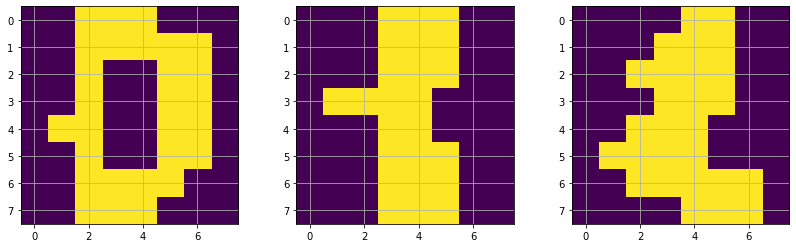

In [12]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

X, y = load_digits(10, True)
X = X > numpy.mean(X)

plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.imshow(X[0].reshape(8, 8), interpolation='nearest')
plt.grid(True)

plt.subplot(132)
plt.imshow(X[1].reshape(8, 8), interpolation='nearest')
plt.grid(True)

plt.subplot(133)
plt.imshow(X[2].reshape(8, 8), interpolation='nearest')
plt.grid(True)

In [80]:
X = X[:,:18]
    
tic = time.time()
model1 = BayesianNetwork.from_samples(X, algorithm='exact-dp') # << BNSL done here!
t1 = time.time() - tic
p1 = model1.log_probability(X).sum()

tic = time.time()
model2 = BayesianNetwork.from_samples(X, algorithm='exact')
t2 = time.time() - tic
p2 = model2.log_probability(X).sum()


print("Shortest Path")
print("Time (s): ", t1)
print("P(D|M): ", p1)
%memit BayesianNetwork.from_samples(X, algorithm='exact-dp')
print()
print("A* Search")
print("Time (s): ", t2)
print("P(D|M): ", p2)
%memit BayesianNetwork.from_samples(X, algorithm='exact')

Shortest Path
Time (s):  91.34069418907166
P(D|M):  -8267.950447476833
peak memory: 1995.34 MiB, increment: 1766.09 MiB

A* Search
Time (s):  61.00853371620178
P(D|M):  -8267.950447476833
peak memory: 720.02 MiB, increment: 489.35 MiB


In [81]:
tic = time.time()
model3 = BayesianNetwork.from_samples(X, algorithm='chow-liu') # << Default BNSL setting
t = time.time() - tic
p = model3.log_probability(X).sum()

print("Chow-Liu")
print("Time (s): ", t)
print("P(D|M): ", p)
%memit BayesianNetwork.from_samples(X, algorithm='chow-liu')

Chow-Liu
Time (s):  0.06877636909484863
P(D|M):  -8752.32666094451
peak memory: 240.11 MiB, increment: 0.00 MiB


In [ ]:
tic = time.time()
model4 = BayesianNetwork.from_samples(X, algorithm='greedy') # << Default BNSL setting
t = time.time() - tic
p = model4.log_probability(X).sum()

print("Greedy")
print("Time (s): ", t)
print("P(D|M): ", p)
%memit BayesianNetwork.from_samples(X, algorithm='greedy')

In [86]:
print(model1.structure)
print()
print(model2.structure)
print()
print(model3.structure)
print()
print(model4.structure)

((), (9,), (0, 3, 8, 16), (0, 8, 16), (2, 5, 12, 13), (3, 13, 16), (5, 14, 16), (6, 15, 16), (0,), (2, 16, 17), (2, 3, 16), (0, 2, 3, 8, 16), (3, 11, 16), (8, 10, 11, 12, 16), (2, 5, 13, 16), (13, 14, 16), (0, 8), (5, 10, 12, 16))

((), (9,), (0, 3, 8, 10), (0, 8), (2, 5, 12, 13), (3, 13), (5, 14), (6, 15), (0,), (2, 16, 17), (0, 3, 8), (2, 3), (3, 11), (8, 10, 11, 12), (2, 5, 13), (13, 14), (3, 4, 5, 8, 10, 11, 12, 13), (5, 10, 12, 16))

((), (0,), (9,), (10,), (5,), (13,), (5,), (6,), (0,), (1,), (2,), (13,), (4,), (10,), (6,), (7,), (0,), (9,))

((), (0, 8, 16), (0, 9, 10, 11), (0, 11), (0, 3), (0, 4, 6, 13, 14), (0, 4, 7), (0,), (0,), (0, 10, 11), (0, 3, 11, 14), (0,), (0, 3, 4), (0, 4, 10, 12, 14), (0, 6, 15), (0, 7), (0, 8), (0, 9, 10))


#### Comparison

In [87]:
X, _ = load_digits(10, True)
X = X > numpy.mean(X)

t1, t2, t3, t4 = [], [], [], []
p1, p2, p3, p4 = [], [], [], []
n_vars = range(8, 19)

for i in n_vars:
    X_ = X[:,:i]

    tic = time.time()
    model = BayesianNetwork.from_samples(X_, algorithm='exact-dp') # << BNSL done here!
    t1.append(time.time() - tic)
    p1.append(model.log_probability(X_).sum())

    tic = time.time()
    model = BayesianNetwork.from_samples(X_, algorithm='exact')
    t2.append(time.time() - tic)
    p2.append(model.log_probability(X_).sum())

    tic = time.time()
    model = BayesianNetwork.from_samples(X_, algorithm='greedy')
    t3.append(time.time() - tic)
    p3.append(model.log_probability(X_).sum())

    tic = time.time()
    model = BayesianNetwork.from_samples(X_, algorithm='chow-liu')
    t4.append(time.time() - tic)
    p4.append(model.log_probability(X_).sum())

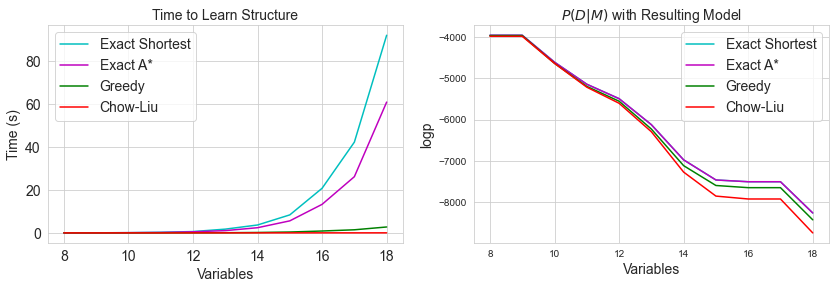

In [88]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.title("Time to Learn Structure", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Time (s)", fontsize=14)
plt.xlabel("Variables", fontsize=14)
plt.plot(n_vars, t1, c='c', label="Exact Shortest")
plt.plot(n_vars, t2, c='m', label="Exact A*")
plt.plot(n_vars, t3, c='g', label="Greedy")
plt.plot(n_vars, t4, c='r', label="Chow-Liu")
plt.legend(fontsize=14, loc=2)

plt.subplot(122)
plt.title("$P(D|M)$ with Resulting Model", fontsize=14)
plt.xlabel("Variables", fontsize=14)
plt.ylabel("logp", fontsize=14)
plt.plot(n_vars, p1, c='c', label="Exact Shortest")
plt.plot(n_vars, p2, c='m', label="Exact A*")
plt.plot(n_vars, p3, c='g', label="Greedy")
plt.plot(n_vars, p4, c='r', label="Chow-Liu")
plt.legend(fontsize=14)

In [76]:
X, y = load_digits(10, True)
numpy.mean(X)

4.884164579855314

In [74]:
print(X[1])
X[0].reshape(8, 8)

[False False False  True  True  True False False False False False  True
  True  True False False False False False  True  True  True False False
 False  True  True  True  True False False False False False False  True
  True False False False False False False  True  True  True False False
 False False False  True  True  True False False False False False  True
  True  True False False]


array([[False, False,  True,  True,  True, False, False, False],
       [False, False,  True,  True,  True,  True,  True, False],
       [False, False,  True, False, False,  True,  True, False],
       [False, False,  True, False, False,  True,  True, False],
       [False,  True,  True, False, False,  True,  True, False],
       [False, False,  True, False, False,  True,  True, False],
       [False, False,  True,  True,  True,  True, False, False],
       [False, False,  True,  True,  True, False, False, False]])

In [54]:
print(len(X[0]))
X

64


array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [45]:
print(len(y))
y

1797


array([0, 1, 2, ..., 8, 9, 8])

In [77]:
print(X[0])
print(numpy.mean(X[0]))
print(y[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
4.59375
0


In [60]:
print(X[231])
print(y[231])

[ 0.  0.  5. 11. 16. 16.  8.  0.  0.  0. 15. 14.  8. 12. 15.  0.  0.  0.
  0.  0.  2. 14.  9.  0.  0.  0.  0.  0. 11. 12.  1.  0.  0.  0.  0.  1.
 16.  5.  0.  0.  0.  0.  0.  1. 14.  9.  0.  0.  0.  0.  1.  4. 15.  9.
  0.  0.  0.  0.  7. 16. 11.  2.  0.  0.]
3


In [42]:
A = X > numpy.mean(X)
A

array([[False, False,  True, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True,  True, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False,  True, ...,  True, False, False]])

In [89]:
import networkx
from pomegranate.utils import plot_networkx

constraints = networkx.DiGraph()
constraints.add_edge('genetic conditions', 'diseases')
constraints.add_edge('diseases', 'symptoms')
plot_networkx(constraints)


ModuleNotFoundError: No module named 'pygraphviz'

In [31]:
import pandas as pd
import numpy as np
from pomegranate import * 
from sklearn.model_selection import train_test_split

df = pd.read_csv('./Data/해양경찰청_해상조난사고_상세데이터_현황_20191231.csv', encoding='euckr')
df.rename(columns={'선 종':'선종'},inplace=True)
df = df[['발생일시','관할해경서','발생해역','기상상태','발생원인','발생유형','선종']]
df = df.drop_duplicates()
df['사고월']=df['발생일시'].apply(lambda x: 'January' if x.split('-')[1]=='01' \
                                    else 'February' if x.split('-')[1]=='02'\
                                    else 'March' if x.split('-')[1]=='03'\
                                    else 'April' if x.split('-')[1]=='04'\
                                    else 'May' if x.split('-')[1]=='05'\
                                    else 'June' if x.split('-')[1]=='06'\
                                    else 'July' if x.split('-')[1]=='07'\
                                    else 'August' if x.split('-')[1]=='08'\
                                    else 'September' if x.split('-')[1]=='09'\
                                    else 'October' if x.split('-')[1]=='10'\
                                    else 'November' if x.split('-')[1]=='11'\
                                    else 'December' if x.split('-')[1]=='12'\
                                    else 'etc'
                           )

df = df[['관할해경서','발생해역','기상상태','발생원인','발생유형','선종','사고월']]

# train set, test set split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
ar = df.to_numpy()
print(ar.shape)

(3633, 7)


In [32]:
model = BayesianNetwork.from_samples(ar, algorithm='exact')
print(model.structure)

((1,), (3,), (), (4,), (), (1,), ())


In [8]:
model = BayesianNetwork.from_samples(ar, algorithm='exact-dp')
print(model.structure)

((1,), (3,), (), (4,), (), (1,), ())


In [9]:
model = BayesianNetwork.from_samples(ar, algorithm='greedy')
print(model.structure)

((1,), (), (), (1,), (3,), (1,), ())


In [10]:
model = BayesianNetwork.from_samples(ar, algorithm='chow-liu')
print(model.structure)

((), (0,), (0,), (4,), (5,), (0,), (0,))


In [12]:
import networkx as nx

In [27]:
font_name

'NanumGothic'

In [ ]:
font_name

In [26]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

font_paths = [(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]
for i in font_paths:
    print(i)
path = 'C:\\Users\\JIHYUN\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothic.ttf'


font_name = fm.FontProperties(fname=path).get_name()
plt.rc('font', family=font_name, size=30)

('NanumGothic', 'C:\\Users\\JIHYUN\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothicBold.ttf')
('NanumGothic', 'C:\\Users\\JIHYUN\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothicExtraBold.ttf')
('NanumGothic', 'C:\\Users\\JIHYUN\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothicLight.ttf')
('NanumGothic', 'C:\\Users\\JIHYUN\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothic.ttf')


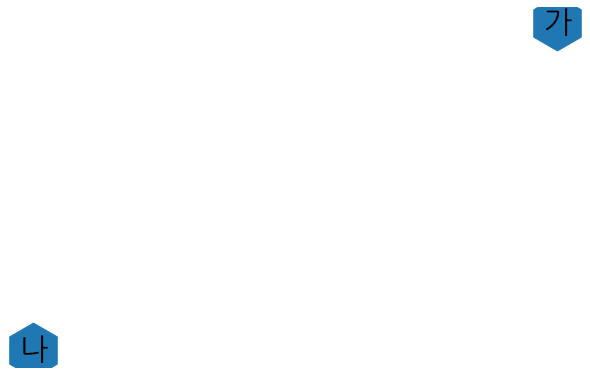

In [30]:
import networkx as nx

fig = plt.figure(figsize=(8, 5))
g = nx.DiGraph()
g.add_nodes_from(['가','나'])
nx.draw(g, with_labels=True,font_family=font_name, edge_color='gray', node_size=3000, node_shape='h'\
       , cmap=plt.cm.Blues, font_size=30)
plt.show()

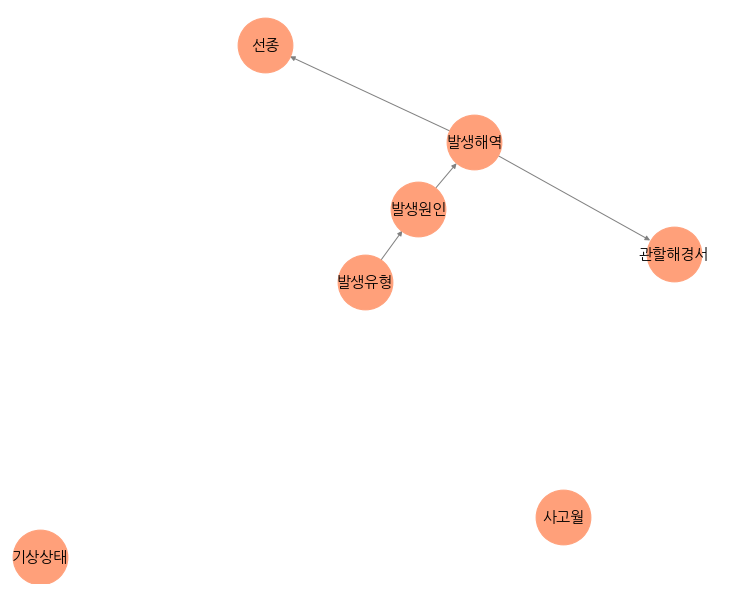

In [72]:
g = nx.DiGraph()
g.add_nodes_from(df.columns.tolist())
g.add_edges_from(edges)

fig = plt.figure(figsize=(10, 8))

pos = nx.spring_layout(g)
nx.draw(g, with_labels=True,font_family=font_name, edge_color='gray', node_size=3000, node_color='lightsalmon'\
       , cmap=plt.cm.Blues, font_size=15)

In [73]:
nodes = df.columns.tolist()
structure = model.structure

In [74]:
edges = []
for i in range(len(nodes)):
    try:
        edges.append((nodes[structure[i][0]], nodes[i]))
    except IndexError:
        pass

In [52]:
edges

[('발생해역', '관할해경서'), ('발생원인', '발생해역'), ('발생유형', '발생원인'), ('발생해역', '선종')]

In [7]:
import math

a = -3
math.exp(a)

0.049787068367863944